In [3]:
import numpy as np
import readtrc, lecroy
import matplotlib.pyplot as plt
import math
from lmfit import Model

In [4]:
def read_file(filename):
    y, metadata = readtrc.read_trc_file(filename)
    y_uV = readtrc.convert_to_uV(y,metadata)
    x_time = set_time_axis(y_uV,metadata)
    return x_time, y_uV

def set_time_axis(y_uV,metadata):
    x_time = np.linspace(0,y_uV.size,y_uV.size)
    if (metadata['INSTRUMENT_NAME']=='LECROYSDA5000'):
        x_time*0.1 #czas w ns
    else:
        x_time*0.4
    return x_time

def convert_to_mV(x):
    return x*1e-3
    
def create_histogram(y):
    xlab = "voltage [mV]"
    ylab = "counts"
    n = int(np.ptp(y)/2000)
    weights = np.ones_like(y)/float(len(y))
    
    ydata, x = np.histogram(y, n, weights=weights)
    xdata=[]
    for i in range(0,len(x)-1):
        xdata.append( x[i] + 0.5*(x[i+1]-x[i]) )
    return convert_to_mV(np.array(xdata)), np.array(ydata)

def mstd(y):
    return [convert_to_mV(np.mean(y)), convert_to_mV(np.std(y))]

def mean_val(y):
    return np.mean(y)

def std_dev(y):
    return np.std(y)

def gaussian(x, amp, mi, var):
    return amp * np.exp(-(x-mi)**2 / (2*var**2))

In [56]:
def voltageThreshold(filename,cutoff):
    x_time, y_uV = read_file(filename)
    m_std = mstd(y_uV)
    x_data, y_data = create_histogram(y_uV)
    
    amp = 1/math.sqrt(2*math.pi*m_std[1]**2)
    gmodel = Model(gaussian)
    result = gmodel.fit(y_data,x=x_data,amp=amp,mi=m_std[0],var=m_std[1])
    #print( result.fit_report() )
    
    #cutoff = 0.03*np.amax(y_data)
    #cutoff =1e-6
    #print(cutoff)
    
    signal = np.array( x_data[abs(y_data -result.best_fit)<cutoff] )
    signal = signal[ np.where(signal < 0)]
    #print(signal)
    voltage =  np.amax (signal)
    print(voltage)
    
    plt.plot(x_data, y_data, 'b-', label='data')
    plt.plot(x_data,result.best_fit,'g-',label='fit')
    plt.axvline(x=result.best_values['mi']+result.best_values['var'],color='r',label='mu+std',linestyle='--',linewidth=1.0)
    plt.axvline(x=result.best_values['mi']-result.best_values['var'],color='r',label='mu-std',linestyle='-.',linewidth=1.0)
    plt.axvline(x=result.best_values['mi']+3*result.best_values['var'],color='m',label='mu+3std',linestyle='--',linewidth=1.0)
    plt.axvline(x=result.best_values['mi']-3*result.best_values['var'],color='m',label='mu-3std',linestyle='-.',linewidth=1.0)
    plt.axvline(x=voltage,color='c',label='threshold voltage',linestyle='-',linewidth=1.0)
    plt.xlabel('voltage [mV]')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.ylim(bottom=1e-8,top=1)
    plt.grid(color='y', linestyle=':', linewidth=0.5)
    plt.legend()
    plt.show()
    
    #for i in range(0,len(x_data)):
        
    

-45.7752551020408


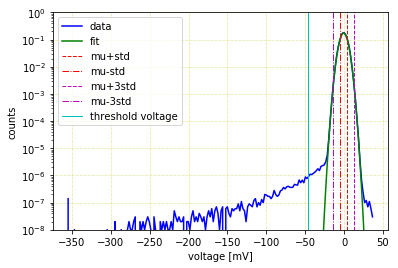

-15.675765306122427


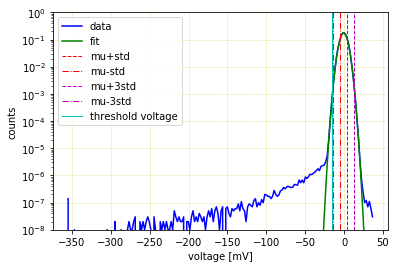

In [57]:
voltageThreshold("450000/C1diamond10000001.trc",1e-6)
voltageThreshold("450000/C1diamond10000001.trc",9e-5)